In [31]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [33]:
# Load the dataset
file_path = 'EVChargingStationUsage.csv'  # Update with your actual file path
df = pd.read_csv(file_path)

C:\Users\krist\AppData\Local\Temp\ipykernel_30184\1987624747.py:3: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [67]:
# Convert date columns to datetime format
df['Start Date'] = pd.to_datetime(df['Start Date'], errors = 'coerce')
df['End Date'] = pd.to_datetime(df['End Date'], errors = 'coerce')
df['Transaction Date (Pacific Time)'] = pd.to_datetime(df['Transaction Date (Pacific Time)'], errors = 'coerce')

In [69]:
# Function to convert hh:mm:ss format to hours
def duration_to_hours(duration_str):
    try:
        h, m, s = map(int, duration_str.split(':'))
        return h + m / 60 + s / 3600
    except ValueError:
        return np.nan

In [71]:
# Apply duration conversion for relevant columns
df['Total Duration (hours)'] = df['Total Duration (hh:mm:ss)'].apply(duration_to_hours)
df['Charging Time (hours)'] = df['Charging Time (hh:mm:ss)'].apply(duration_to_hours)

In [72]:
# Create a Date column for daily aggregation
df['Date'] = df['Start Date'].dt.date

In [75]:
# Aggregate data by User ID and Date to get daily usage metrics
user_daily_usage = df.groupby(['User ID', 'Date']).agg({
    'Energy (kWh)': 'sum',
    'Total Duration (hours)': 'sum',
    'Charging Time (hours)': 'sum'
}).reset_index()

In [77]:
# Data Preprocessing for Clustering
# Remove 'User ID' and 'Date' for clustering as they are identifiers, not features
data_for_clustering = user_daily_usage[['Energy (kWh)', 'Total Duration (hours)', 'Charging Time (hours)']]

In [79]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

In [81]:
# Determine the optimal number of clusters using the elbow method
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

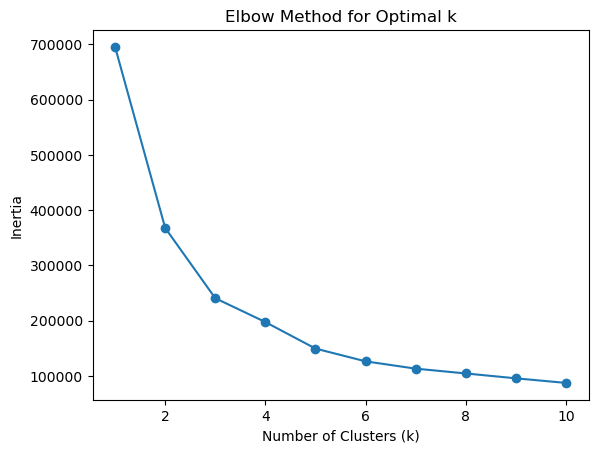

In [82]:
# Plot the elbow curve
plt.plot(k_values, inertia, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [83]:
# Choose the optimal k (e.g., where the elbow appears in the plot)
optimal_k = 3  # Update this based on the elbow plot

# Perform KMeans clustering with the chosen number of clusters
kmeans = KMeans(n_clusters = optimal_k, random_state=0)
user_daily_usage['Cluster'] = kmeans.fit_predict(scaled_data)

# Display cluster assignments
print(user_daily_usage[['User ID', 'Date', 'Energy (kWh)', 'Total Duration (hours)', 'Charging Time (hours)', 'Cluster']].head())


  User ID        Date  Energy (kWh)  Total Duration (hours)  \
0     0.0  2011-08-02      3.516131                1.013889   
1     0.0  2011-08-04      8.740360                2.975833   
2     0.0  2011-08-08      5.956442                1.723333   
3     0.0  2011-08-18      5.014686                2.406389   
4     0.0  2011-08-27      5.462664                1.890278   

   Charging Time (hours)  Cluster  
0               1.011944        0  
1               2.957500        1  
2               1.721667        0  
3               1.714722        0  
4               1.886944        0  


In [84]:
# Apply PCA for 2D visualization
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(scaled_data)
user_daily_usage['PCA1'] = pca_data[:, 0]
user_daily_usage['PCA2'] = pca_data[:, 1]

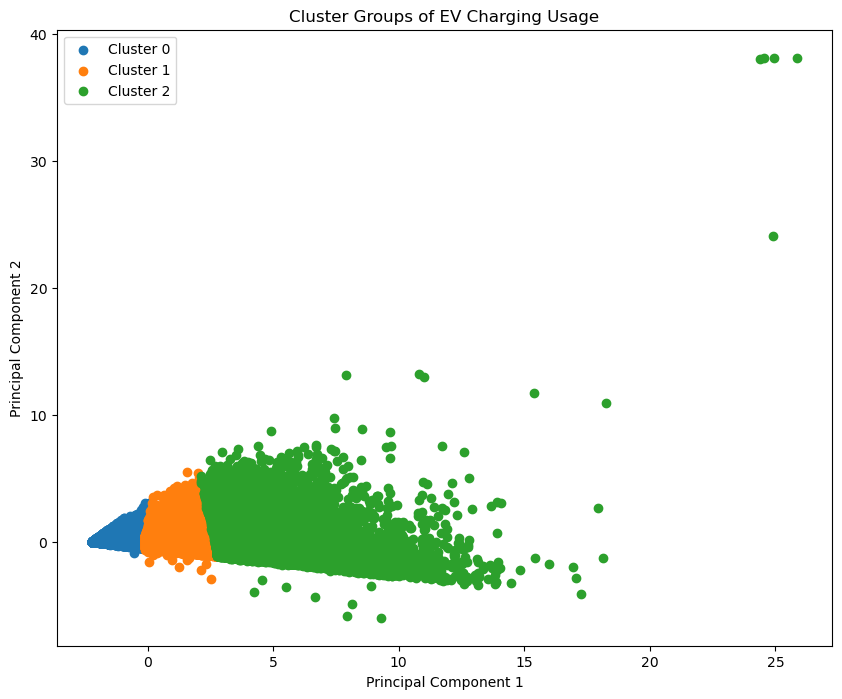

In [89]:
# Plot the cluster groups in 2D space
plt.figure(figsize = (10, 8))
for cluster in range(optimal_k):
    cluster_data = user_daily_usage[user_daily_usage['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label = f'Cluster {cluster}')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Cluster Groups of EV Charging Usage")
plt.legend()
plt.show()

In [90]:
# Save the clustered data
user_daily_usage.to_csv('Clustered_EVChargingStationUsage.csv', index = False)
print("Clustering complete. Clustered data saved to 'Clustered_EVChargingStationUsage.csv'.")

Clustering complete. Clustered data saved to 'Clustered_EVChargingStationUsage.csv'.
